# Looking at Local Crime Data
While looking for local data on education, I stumbled upon the fact that our local police department has made their incident records available to the public via [Socrata](https://moto.data.socrata.com/dataset/El-Cerrito-Police-Department/a9zr-qcds). I don't want to read too much into crime data (there are a lot of underlying racial and socio-economic factors that are not obvious in this type of data), but I thought it would be interesting to do a quick exploration of the data. The three questions that came to mind were:
1. What type of crimes are the most common in El Cerrito? My guess was theft.
1. Is there a time of day when certain crimes happen? I would assume most crimes would occur at night, but this might just be a misunderstanding from too many years of movies and TV.
1. Are there any unexpected crime hot spots? Again, by biases (and the biases of policing resources), I would assume the hotspots would be near the city's homeless encampments and poorer neighborhood

First, I pull the data in and just check out the dataframe.

In [19]:
# import libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline

# libraries for map making
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox

# libraries for heatmap
from scipy import ndimage
from PIL import Image

from IPython.core.display import HTML, display

pd.set_option('display.max_columns', None)

In [2]:
# create dataframe of police records
records = pd.read_csv('El_Cerrito_Police_Department_072518.csv', parse_dates=['incident_datetime'])
records.head()

,incident_id,case_number,incident_datetime,incident_type_primary,incident_description,clearance_type,address_1,address_2,city,state,zip,country,latitude,longitude,created_at,updated_at,location,hour_of_day,day_of_week,parent_incident_type
0,107468287,2009-00009784,2009-05-25 23:45:00,PC 459 BURGLARY/BREAKING AND ENTERING,PC 459 BURGLARY/BREAKING AND ENTERING,NaN,6700 Block SCHMIDT LN,NaN,EL CERRITO,CA,94530,NaN,37.915473,-122.307195,04/17/2012 09:42:23 PM,10/29/2015 10:33:46 AM,POINT (-122.3071947 37.9154732),23,Monday,Breaking & Entering
1,107467468,2009-00017553,2009-09-17 19:00:00,PC 215 CARJACKING,PC 215 CARJACKING,NaN,CUTTING BLVD & BART PATH,NaN,EL CERRITO,CA,NaN,NaN,37.925892,-122.317444,04/17/2012 09:42:02 PM,04/17/2015 07:16:14 AM,POINT (-122.317443863 37.925892151),19,Thursday,Robbery
2,107466426,2010-00002184,2010-01-30 19:01:00,PC 12031 (a) CARRY CONCEALED/LOADED FIREARM: N...,PC 12031 (a) CARRY CONCEALED/LOADED FIREARM: N...,NaN,11300 Block SAN PABLO AVE,NaN,EL CERRITO,CA,NaN,NaN,37.921431,-122.315569,04/17/2012 09:41:41 PM,09/17/2015 10:35:36 AM,POINT (-122.315568944197 37.921431408155),19,Saturday,Weapons Offense
3,107466057,2010-00003517,2010-02-16 08:41:00,HS 11377 FEL - POSS CONTROLLED SUBSTANCE,HS 11377 FEL - POSS CONTROLLED SUBSTANCE,NaN,PORTOLA DR & BART PATH,NaN,EL CERRITO,CA,NaN,NaN,37.913400,-122.308000,04/17/2012 09:41:36 PM,09/16/2015 10:34:29 AM,POINT (-122.308 37.9134),8,Tuesday,Drugs
4,107464734,2010-00016844,2010-08-24 22:06:00,PC 496 RECEIVE/ETC STOLEN PROP -$400,PC 496 RECEIVE/ETC STOLEN PROP -$400,NaN,CARLSON BLVD & HUNTINGTON AVE,NaN,RICHMOND,CA,NaN,NaN,37.907741,-122.308556,04/17/2012 09:41:08 PM,08/02/2016 07:13:32 AM,POINT (-122.308556426 37.9077406270001),22,Tuesday,Theft


In [3]:
records.tail()

,incident_id,case_number,incident_datetime,incident_type_primary,incident_description,clearance_type,address_1,address_2,city,state,zip,country,latitude,longitude,created_at,updated_at,location,hour_of_day,day_of_week,parent_incident_type
7347,826528776,2017-00022902,2017-11-11 02:21:47,HIT AND RUN,HIT AND RUN,NaN,11800 Block SAN PABLO AVE,NaN,EL CERRITO,CA,NaN,NaN,37.9282,-122.321,11/12/2017 08:10:34 AM,05/09/2018 12:49:53 AM,POINT (-122.321 37.9282),2,Saturday,Traffic
7348,826528777,2017-00022939,2017-11-11 16:38:45,ACCIDENT,ACCIDENT,NaN,11400 Block SAN PABLO AVE,NaN,EL CERRITO,CA,NaN,NaN,37.9226,-122.316,11/12/2017 08:10:34 AM,05/09/2018 12:49:53 AM,POINT (-122.316 37.9226),16,Saturday,Traffic
7349,826576318,2017-00022990,2017-11-12 12:23:00,ACCIDENT,ACCIDENT,NaN,11100 Block SAN PABLO AVE,NaN,EL CERRITO,CA,NaN,NaN,37.9187,-122.314,11/13/2017 08:10:33 AM,05/11/2018 12:41:37 PM,POINT (-122.314 37.9187),12,Sunday,Traffic
7350,826576319,2017-00022991,2017-11-12 12:44:00,HIT AND RUN,HIT AND RUN,NaN,10900 Block SAN PABLO AVE,NaN,EL CERRITO,CA,NaN,NaN,37.9164,-122.312,11/13/2017 08:10:33 AM,05/11/2018 12:41:38 PM,POINT (-122.312 37.9164),12,Sunday,Traffic
7351,826644671,2017-00023061,2017-11-13 19:22:55,HIT AND RUN,HIT AND RUN,NaN,EUREKA AVE,NaN,EL CERRITO,CA,NaN,NaN,37.9061,-122.305,11/14/2017 08:10:33 AM,05/12/2018 09:29:30 AM,POINT (-122.305 37.9061),19,Monday,Traffic


In [4]:
records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Data columns (total 20 columns):
incident_id              7352 non-null int64
case_number              7352 non-null object
incident_datetime        7352 non-null datetime64[ns]
incident_type_primary    7352 non-null object
incident_description     7352 non-null object
clearance_type           0 non-null float64
address_1                7348 non-null object
address_2                0 non-null float64
city                     7352 non-null object
state                    7352 non-null object
zip                      464 non-null object
country                  0 non-null float64
latitude                 7351 non-null float64
longitude                7351 non-null float64
created_at               7352 non-null object
updated_at               7352 non-null object
location                 7351 non-null object
hour_of_day              7352 non-null int64
day_of_week              7352 non-null object
parent_incident_ty

In [4]:
# get most recent incident report
records.incident_datetime.max()

Timestamp('2018-07-22 07:51:39')

In [20]:
# number of incidents per city
records.city.value_counts()

EL CERRITO     6749
RICHMOND        568
SAN PABLO        14
KENSINGTON       11
Richmond          2
LAFAYETTE         2
El Cerrito        2
PINOLE            1
ALBANY            1
EC                1
EL CDERRITO       1
Name: city, dtype: int64

In [8]:
# drop the empty and unnecessary columns
cols = ['incident_datetime','incident_type_primary', 'incident_description',
        'address_1', 'city', 'latitude', 'longitude', 'location', 'hour_of_day',
        'day_of_week', 'parent_incident_type']

# create a dataframe consisting only of El Cerrito data from 2017 and 2018
ec_records_2017 = records[cols]
ec_records_2017 = ec_records_2017[(ec_records_2017['incident_datetime'] > '2017-01-01') 
                                  & (ec_records_2017['city'] == 'EL CERRITO')]

## Mapping Crime
Now I want to use `GeoPandas` and `osmnx` to be able to easily convert the data into geolocated points with a basic street map of El Cerrito.

In [9]:
# convert longitude and latitude coordinates to points
points = ec_records_2017.apply(lambda row: Point(row.longitude, row.latitude), axis=1)

# create a geodataframe of incidents for mapping
records_map = gpd.GeoDataFrame(ec_records_2017, geometry=points)
records_map.crs = {'proj':'merc'}

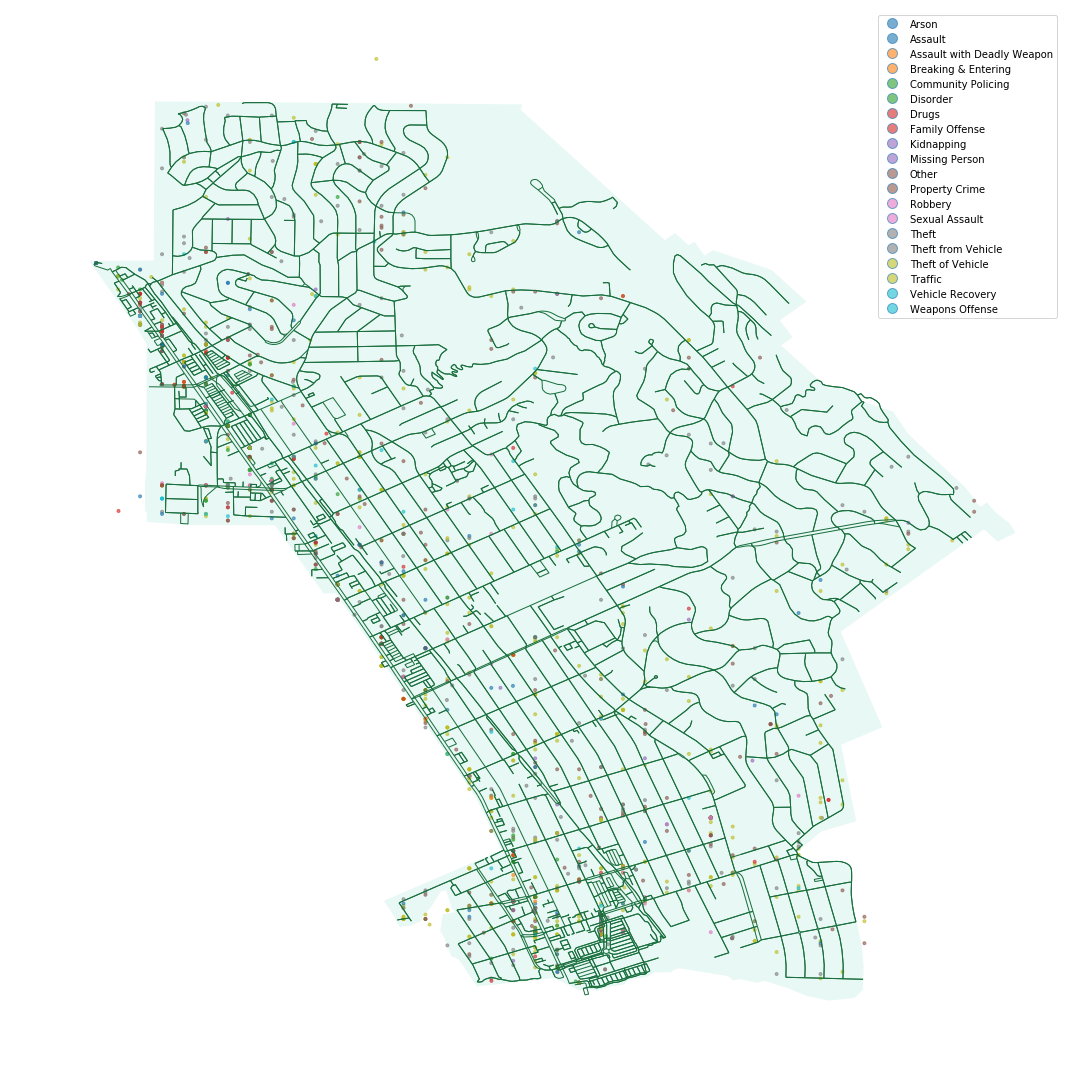

In [10]:
# create a map of incidents
# set place name for osmnx
place_name = "El Cerrito, Contra Costa County, California, United States of America"

# generate background map of El Cerrito
graph = ox.graph_from_place(place_name)
nodes, edges = ox.graph_to_gdfs(graph) # street map
area = ox.gdf_from_place(place_name) # boundary map

# plot incidents on map by type
fig, ax = plt.subplots(figsize=(15,15))
area.plot(ax=ax, facecolor='#E8F8F5')
edges.plot(ax=ax, linewidth=1, edgecolor='#196F3D')
records_map.plot(figsize=(15,15), column='parent_incident_type', legend=True, alpha=0.6, marker='.', ax=ax)
plt.axis('off')
plt.tight_layout()

In [5]:
# limit police records to El Cerrito city limits
ec_records = records[records['city'] == 'EL CERRITO']

# create dataframe of records from 2017 to most recent
ec_records_2017 = ec_records[ec_records['incident_datetime'] > '2017-01-01']
ec_records.head()

,incident_id,case_number,incident_datetime,incident_type_primary,incident_description,clearance_type,address_1,address_2,city,state,zip,country,latitude,longitude,created_at,updated_at,location,hour_of_day,day_of_week,parent_incident_type
0,107468287,2009-00009784,2009-05-25 23:45:00,PC 459 BURGLARY/BREAKING AND ENTERING,PC 459 BURGLARY/BREAKING AND ENTERING,NaN,6700 Block SCHMIDT LN,NaN,EL CERRITO,CA,94530,NaN,37.915473,-122.307195,04/17/2012 09:42:23 PM,10/29/2015 10:33:46 AM,POINT (-122.3071947 37.9154732),23,Monday,Breaking & Entering
1,107467468,2009-00017553,2009-09-17 19:00:00,PC 215 CARJACKING,PC 215 CARJACKING,NaN,CUTTING BLVD & BART PATH,NaN,EL CERRITO,CA,NaN,NaN,37.925892,-122.317444,04/17/2012 09:42:02 PM,04/17/2015 07:16:14 AM,POINT (-122.317443863 37.925892151),19,Thursday,Robbery
2,107466426,2010-00002184,2010-01-30 19:01:00,PC 12031 (a) CARRY CONCEALED/LOADED FIREARM: N...,PC 12031 (a) CARRY CONCEALED/LOADED FIREARM: N...,NaN,11300 Block SAN PABLO AVE,NaN,EL CERRITO,CA,NaN,NaN,37.921431,-122.315569,04/17/2012 09:41:41 PM,09/17/2015 10:35:36 AM,POINT (-122.315568944197 37.921431408155),19,Saturday,Weapons Offense
3,107466057,2010-00003517,2010-02-16 08:41:00,HS 11377 FEL - POSS CONTROLLED SUBSTANCE,HS 11377 FEL - POSS CONTROLLED SUBSTANCE,NaN,PORTOLA DR & BART PATH,NaN,EL CERRITO,CA,NaN,NaN,37.913400,-122.308000,04/17/2012 09:41:36 PM,09/16/2015 10:34:29 AM,POINT (-122.308 37.9134),8,Tuesday,Drugs
5,107464182,2010-00022540,2010-11-18 05:59:00,VC 20001 A HIT AND RUN:DEATH/INJURY,VC 20001 A HIT AND RUN:DEATH/INJURY,NaN,POTRERO AVE & S 56TH ST,NaN,EL CERRITO,CA,NaN,NaN,37.920800,-122.317000,04/17/2012 09:40:52 PM,05/26/2015 07:20:37 AM,POINT (-122.317 37.9208),5,Thursday,Traffic


To make sense of the individual points would either require separate maps for different incident types or a much larger map that can be zoomed in for detail.  I don't really want to spend the time creating, let alone looking at, those maps, so I am just going to create a quick heatmap to get a sense of crime density. This does not allow me to see what types of crimes are happening where, but this is just a quick exercise in curiosity.

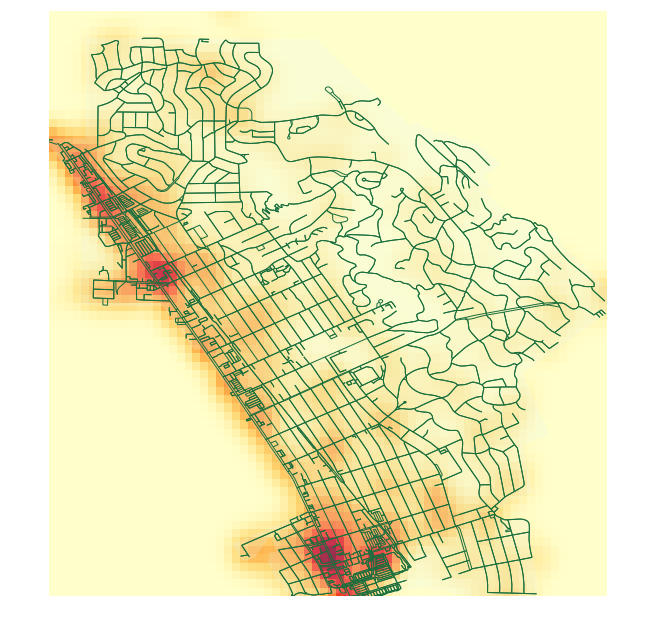

In [22]:
# create a heatmap to visualize crime density
def heatmap(d, bins=(100,100), smoothing=1.3, cmap=pylab.cm.YlOrRd):
    '''
    Function to filter data points
    into a blurred distribution
    '''
    def getx(pt):
        '''
        Function to get x-coordinates
        '''
        return pt.coords[0][0]

    def gety(pt):
        '''
        Function to get y-coordinates
        '''
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap+1)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.gca().invert_yaxis()

# plot heatmap with El Cerrito map
fig, ax = plt.subplots(figsize=(10,20))
area.plot(ax=ax, facecolor='#E8F8F5', alpha=0.2)
edges.plot(ax=ax, linewidth=1, edgecolor='#196F3D')
heatmap(records_map, bins=70, smoothing=1.5)

plt.axis('off')
plt.show()
plt.savefig('2017_heatmap.png')

It looks like the police incidents are heavily centered near the two interstate on/off ramps. I assume that traffic-related incidents are probably skewing this data, so I want to create a heatmap without the traffic data.

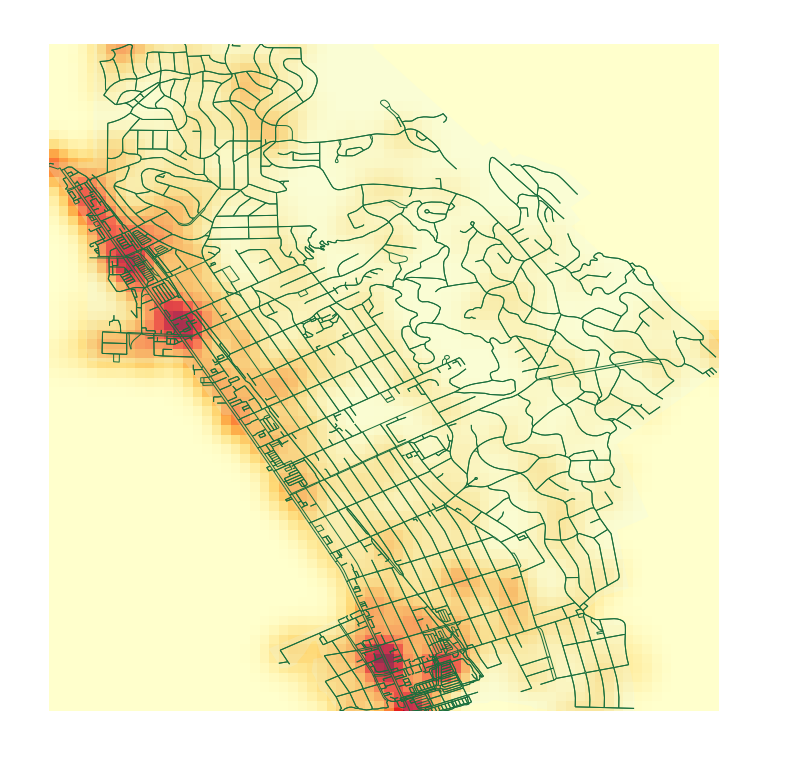

In [17]:
# create a heatmap without traffic
# filter records for Traffic incidents
mask = records_map.parent_incident_type.isin(['Traffic'])

# mask records with inverse of Traffic incidents
no_traffic = records_map[~mask]

fig, ax = plt.subplots(figsize=(12,15))
area.plot(ax=ax, facecolor='#E8F8F5', alpha=0.2)
edges.plot(ax=ax, linewidth=1, edgecolor='#196F3D')
heatmap(no_traffic, bins=70, smoothing=1.5)

plt.axis('off')

plt.savefig('2017_heatmap_notraffic.png')

Surprisingly it does not look like getting rid of traffic incidents changes the heatmap much. There seems to be a slight reduction of density around the interstate exits and a slight increase in density in other parts of the city. Let's look more into the types of crimes that are prevalent in El Cerrito.

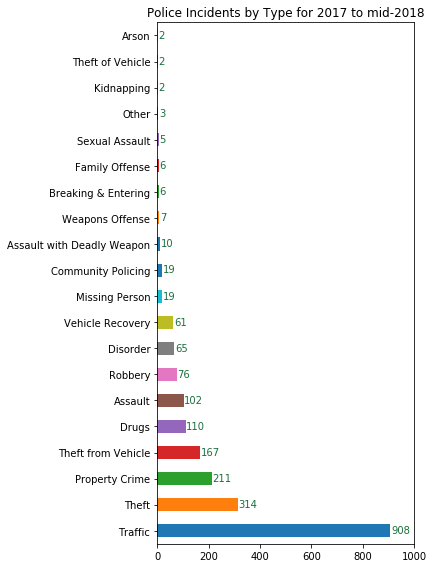

In [136]:
# bar plot of number of incidents by type
fig, ax = plt.subplots(figsize=(6,8))
incidents = ec_records_2017['parent_incident_type'].value_counts()

ax = incidents.plot(kind='barh')
for i, v in enumerate(incidents):
    ax.text(v+3, i-.1, str(v), color='#196F3D', fontweight='normal')
ax.set_title('Police Incidents by Type for 2017 to mid-2018')
plt.tight_layout()
plt.savefig('2017_incidents_by_type.png', facecolor=None, edgecolor=None,
        transparent=True)
plt.xticks(np.arange(0, 1100, step=200))
plt.show()

Well, there are certainly a lot of traffic incidents relative to other incident types. The next three most common incident types (theft, property crime, and theft from vehicle) confirm my bias and also help to explain the hot spots on the crime density maps. In addition to the hotspots focusing around the interstate exits, these are also dense commercial areas. So it can be reasoned that theft in commercial spaces (or their parking lots) is more common than in residential areas.

Some rather surprising numbers were the 19 missing persons and 2 kidnappings. Those seem high to me, but I guess I really have no idea what normal is for missing persons and kidnappings. Sexual assault numbers seem low. Nationally the annual rate of sexual assaults is 1.6 per 1000 people. With about 25,000 people in El Cerrito, we would expect to see about 40 reported sexual assaults. Hopefully this means that El Cerrito is a relatively safe place to live (and not that such incidents are underreported). 

I also want to look more into the definitions of 'family offense' and 'community policing'. But for now, let's look at how crimes are distributed throughout the day.

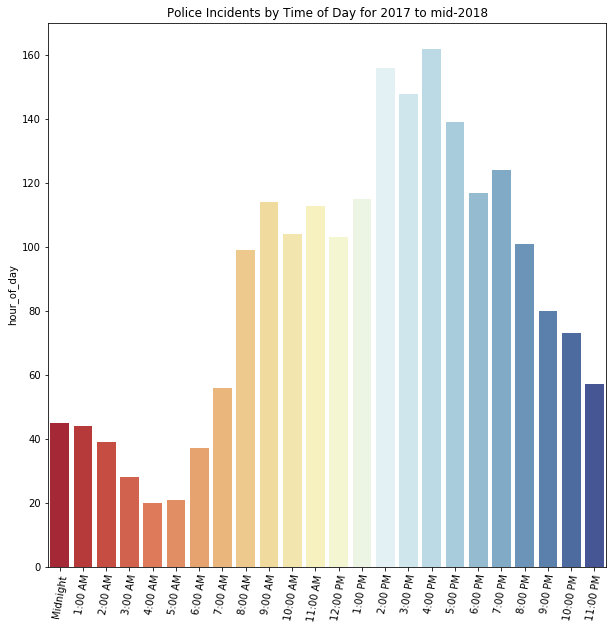

In [10]:
# bar plot of number of incidents by time of day
time = ec_records_2017['hour_of_day'].value_counts(ascending=True)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Police Incidents by Time of Day for 2017 to mid-2018')

ax = sns.barplot(x=time.index ,y=time, palette=sns.color_palette('RdYlBu', 24))
plt.xticks(np.arange(24), ('Midnight','1:00 AM','2:00 AM','3:00 AM','4:00 AM',
                           '5:00 AM','6:00 AM','7:00 AM','8:00 AM','9:00 AM','10:00 AM',
                          '11:00 AM','12:00 PM','1:00 PM','2:00 PM','3:00 PM','4:00 PM',
                           '5:00 PM','6:00 PM','7:00 PM','8:00 PM','9:00 PM','10:00 PM',
                          '11:00 PM'), rotation=80)
plt.savefig('2017_TOD.png')

In [128]:
# mean time of incident
def mean_time(df, col):
    ''' 
    A function to determine the mean time of a column.
    
    Returns: hour, minutes
    '''
    if np.mean(df[col]) >= 12:
        minutes = (np.mean(df[col]) - 12) * 60
        meridian = 'PM'
    else:
        minutes = (np.mean(df[col])) * 60
        meridian = 'AM'
    
    hour, minutes = divmod(minutes, 60)
    
    
    return int(hour), round(int(minutes)), meridian

inc_hour, inc_mins, meridian = mean_time(ec_records_2017, 'hour_of_day')
print("Mean time of incidents is {0}:{1}{2}".format(inc_hour, inc_mins, meridian))

Mean time of incidents is 1:29PM


It looks like all those crime shows fooled me! There seems to be a fairly normal distribution of incidents with the mean around 1:30 PM. This makes sense in the context of most incidents being traffic-related. Combined with the heatmap, it also makes sense that most theft would occur during business hours. Let's plot the incidents by time of day to see if there are any correlational insights.

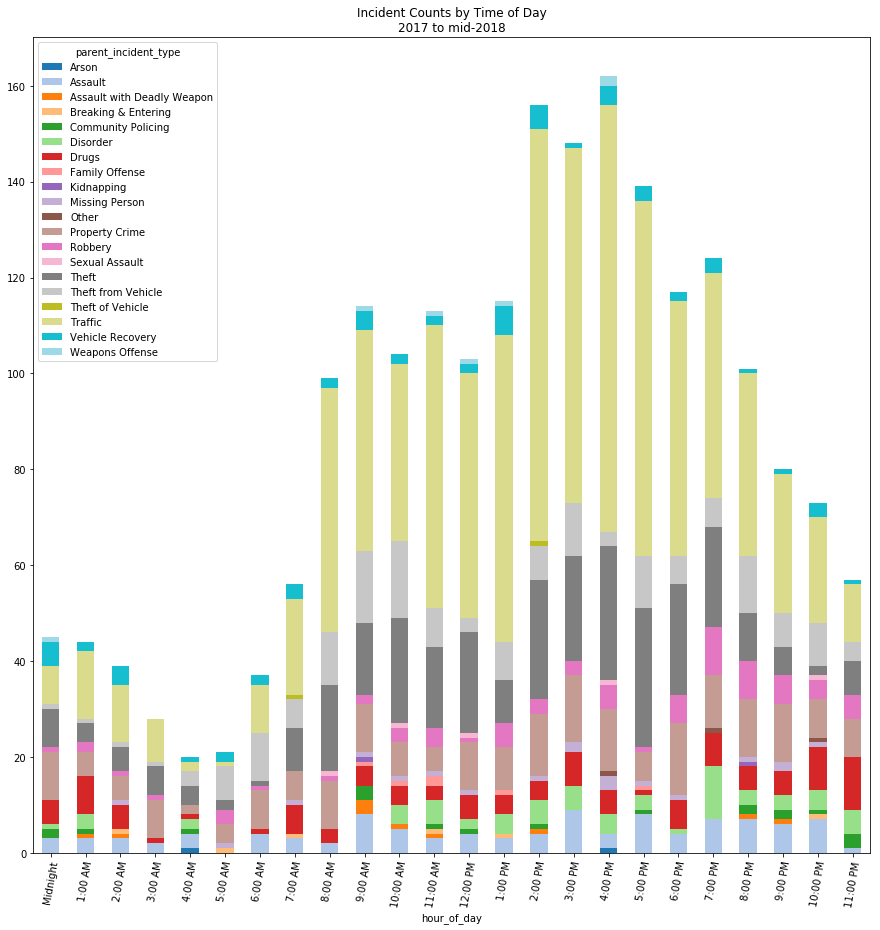

In [111]:
# create dataframe grouped by time of day
inc_by_tod = ec_records_2017[['hour_of_day','parent_incident_type', 'city']].groupby(['hour_of_day','parent_incident_type']).agg('count')['city']

# plot incident counts by time of day
fig,ax = plt.subplots(figsize=(15,15))
ax = inc_by_tod.unstack().plot(kind='bar', ax=ax, width=.5, stacked=True, cmap=plt.cm.get_cmap('tab20'))
plt.title('Incident Counts by Time of Day\n2017 to mid-2018')
plt.xticks(np.arange(24), ('Midnight','1:00 AM','2:00 AM','3:00 AM','4:00 AM',
                           '5:00 AM','6:00 AM','7:00 AM','8:00 AM','9:00 AM','10:00 AM',
                          '11:00 AM','12:00 PM','1:00 PM','2:00 PM','3:00 PM','4:00 PM',
                           '5:00 PM','6:00 PM','7:00 PM','8:00 PM','9:00 PM','10:00 PM',
                          '11:00 PM'), rotation=80)
plt.savefig('2017_incident_stack.png')

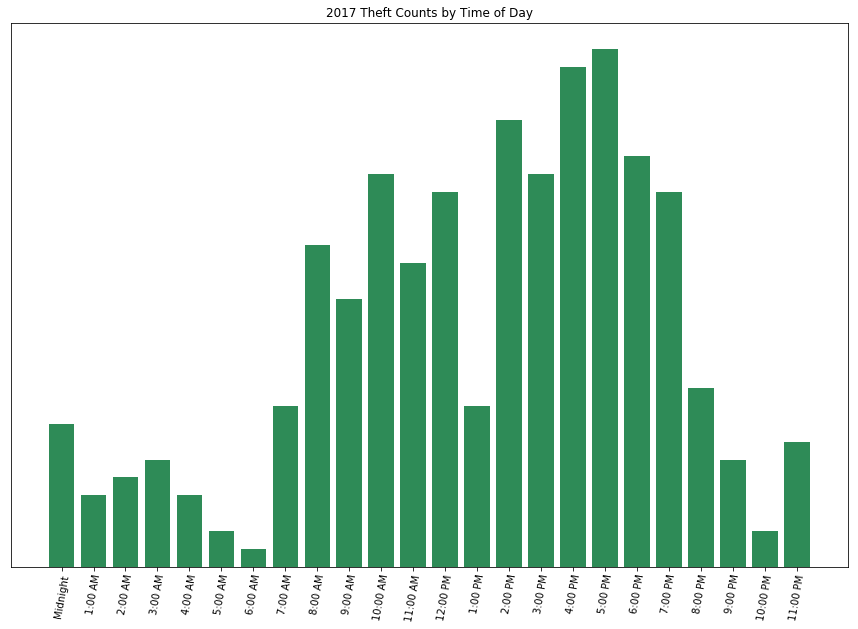

In [120]:
thefts = inc_by_tod.unstack()['Theft'].reset_index()

# plot theft counts by time of day
fig,ax = plt.subplots(figsize=(15,10))
plt.bar(x=thefts.hour_of_day, height=thefts.Theft, width=.8, color='seagreen')
plt.title('2017 Theft Counts by Time of Day')
plt.xticks(np.arange(24), ('Midnight','1:00 AM','2:00 AM','3:00 AM','4:00 AM',
                           '5:00 AM','6:00 AM','7:00 AM','8:00 AM','9:00 AM','10:00 AM',
                          '11:00 AM','12:00 PM','1:00 PM','2:00 PM','3:00 PM','4:00 PM',
                           '5:00 PM','6:00 PM','7:00 PM','8:00 PM','9:00 PM','10:00 PM',
                          '11:00 PM'), rotation=80)
plt.yticks([])
plt.savefig('2017_thefts.png')

In [129]:
theft_hour, theft_mins, meridian = mean_time(thefts, 'hour_of_day')
print("Mean time of incidents is {0}:{1}{2}".format(theft_hour, theft_mins, meridian))

Mean time of incidents is 11:30AM


It looks like thefts are fairly evenly spread from 8:00AM to 7:00PM (with a nice 1:00PM lunch break). This corroborates the belief that thefts are primarily occurring during business hours. One last thing I wanted to look at is how crimes are trending from year-to-year. Unfortunately it looks like we are missing a lot of data from before 2015, so I will just plot the data for each incident type from 2015 to 2017.

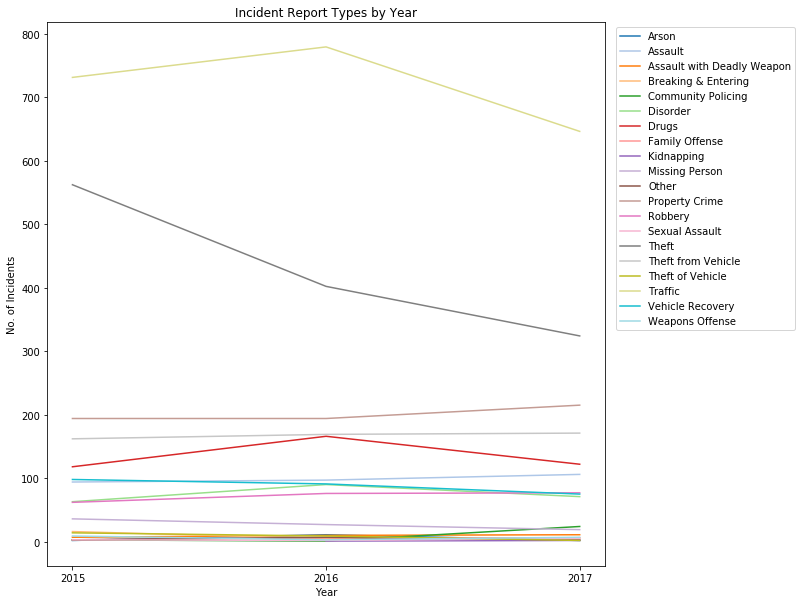

In [134]:
# group incidents by year
year_grp = records[['hour_of_day','parent_incident_type','incident_datetime']].rename(index=str, columns={"hour_of_day": "count", "parent_incident_type": "incident"})
year_grp = year_grp[(year_grp['incident_datetime'] > '2015') & (year_grp['incident_datetime'] < '2018')]
year_grp = year_grp.groupby([year_grp.incident_datetime.dt.year,'incident']).agg('count')['count']

# plot incident type totals by year
fig, ax = plt.subplots(figsize=(10,10))
year_grp.unstack(level=1).plot(subplots=False, ax=ax, cmap=plt.cm.get_cmap('tab20'))
ax.legend(loc='upper right', bbox_to_anchor=(1.35,1.0))
plt.title('Incident Report Types by Year')
plt.xticks(np.arange(2015, 2018, step=1))
plt.xlabel('Year')
plt.ylabel('No. of Incidents')
    
plt.show()
plt.savefig('incident_by_year.png')

Ok, one last calculation. It looks like thefts are actually on the decline while everything else seems to stay pretty steady. Overall, crime rates seem pretty low in El Cerrito. I want to do a quick analysis of crime rates compared to the national average, just to see if they are wildly different or if there is only a slight variation. Source: [Pew Research](http://www.pewresearch.org/fact-tank/2018/01/30/5-facts-about-crime-in-the-u-s/)

In [151]:
# create list of violent crimes in dataframe
violent_crimes = ['Assault', 'Robbery', 'Assault with Deadly Weapon', 'Sexual Assault', 'Kidnapping', 'Arson']

# create list of property crimes in dataframe
property_crimes = ['Property Crime', 'Theft', 'Theft from Vehicle', 'Theft of Vehicle', 'Breaking & Entering']

# count number of violent crimes in 2017
violent_cnt = 0
for crime in incidents[violent_crimes]:
    violent_cnt += crime

# count number of property crimes in 2017
property_cnt = 0
for crime in incidents[property_crimes]:
    property_cnt += crime
    
# calculate the expected number of each category
# the Bureau of Justice reports crimes rates per 1000
# (e.g. 21.1 violent crimes per 1000 people)
expected_violent = 25 * 21.1
expected_property = 25 * 119.4

print('Expected number of violent crimes for El Cerrito: {}'.format(expected_violent))
print('Actual number of violent crimes for El Cerrito: {}'.format(violent_cnt))
print('National average violent crime rate is 21.1 per 1,000. El Cerrito violent crime rate is {:.2f} per 1,000.'.format(violent_cnt/25))
print('='*100)
print('Expected number of property crimes for El Cerrito: {}'.format(expected_property))
print('Actual number of property crimes for El Cerrito: {}'.format(property_cnt))
print('National average property crime rate is 119.4 per 1,000. El Cerrito property crime rate is {:.2f} per 1,000.'.format(property_cnt/25))

Expected number of violent crimes for El Cerrito: 527.5
Actual number of violent crimes for El Cerrito: 197
National average violent crime rate is 21.1 per 1,000. El Cerrito violent crime rate is 7.88 per 1,000.
Expected number of property crimes for El Cerrito: 2985.0
Actual number of property crimes for El Cerrito: 700
National average property crime rate is 119.4 per 1,000. El Cerrito property crime rate is 28.00 per 1,000.


Wow, those crime rates seem *really* low. I find that pretty funny considering I work in a very wealthy part of the Bay and folks in that area all seem to think that were I live is very dangerous and full of crime.

## In conclusion
Let's see where I stand with my hypotheses/biases:
1. Is theft the most common incident? No, traffic incidents far outweight theft, but theft does come in 2nd and 4th
1. Do most crimes would occur at night? Wrong again. Most occur in the middle of the day.
1. Are the city's homeless encampments and poorer neighborhoods hotspots for crime? Sorta, maybe. We might have to drill down into more detail to get a complete picture. This is complicated by the fact that homeless encampments and poorer communities seem to focus around the interstate exchanges and commercial areas. The data does **not** make any conclusions about whether homeless or impoverished people are more likely to commit crimes.

I suppose the moral of the story is **TEST YOUR HYPOTHESIS!** Dig deeper into your own biases! See if it is easy to prove yourself wrong. If it is, you genuinely learned something. Some other interesting findings:
* police incidents seem to remain steady across types (with a decrease in thefts)
* El Cerrito seems well below the national average on apparently all crime statistics
* the police officer at the 4th of July Festival was right, we *are* really low on murders (as in zero)

Well this was a fun little side project that I was not expecting to do. Maybe because this information hits so close to home, I found this project really interesting. I hope to have time to come back to this data and update when I can. Maybe I can create a community dashboard for the neighbors to easily check. Constructive feedback is always welcome.

### Side Note
While I was putting this together I shared it with my neighbors. Once of them asked about a forced entry that had happened nearby a little over a month ago. I looked to see if it was in the dataset only to find that only 4 non-traffic related incidents are reported for 2018. This indicates that we really cannot make any inferences from 2018 data and should have left it out all together.

In [92]:
records[(records['incident_datetime'] > '2018-01-01') & (records['parent_incident_type'] != 'Traffic')].describe()

,incident_id,clearance_type,address_2,country,latitude,longitude,hour_of_day
count,4.000000e+00,0.0,0.0,0.0,4.000000,4.000000,4.00
mean,8.336953e+08,NaN,NaN,NaN,37.911185,-122.296697,13.75
std,4.294527e+05,NaN,NaN,NaN,0.010740,0.004870,5.50
min,8.334806e+08,NaN,NaN,NaN,37.903528,-122.301661,6.00
25%,8.334806e+08,NaN,NaN,NaN,37.904221,-122.300481,12.75
50%,8.334806e+08,NaN,NaN,NaN,37.907254,-122.296423,15.00
75%,8.336953e+08,NaN,NaN,NaN,37.914218,-122.292639,16.00
max,8.343395e+08,NaN,NaN,NaN,37.926703,-122.292281,19.00
